In [1]:

"""
Figures & tables for results of rooftop mapping in Washington D.C. and Denver, Colorado

Main text: 

Figure 1. Study area map, roof materials distribution, and building footprint area.

Figure 2. Example image chunks from satellite imagery for all classes (see _plot-image-chunks-DC.ipynb)

Figure 3. CNN model loss function across folds for both regions.

Figure 4. Results from CV - model accuracy metrics.

Supplement
Figure S1. Band correlations.
Figure S2. Confusion matrices.
Figure S3. Results from tuning workflow.

"""

import os, sys
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import earthpy.plot as ep
import seaborn as sns
import matplotlib as mpl
import numpy as np
import earthpy.plot as ep

from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print(os.getcwd())

projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready!")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Ready!


## Fig. 1: Study area map and distribution of training data

- 1a) Distribution of roof material classes
- 1b) Map of the study region
- 1c) Distribution of building sizes by roof material

In [2]:
# Load the footprint data for both ROIs

# Washington D.C.
fp = os.path.join(projdir, 'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
dc_ref = gpd.read_file(fp)
# Denver, Colorado
fp = os.path.join(projdir, 'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
denver_ref = gpd.read_file(fp)

# Create a dictionary for data access:
refs = {'DC': dc_ref, 'Denver': denver_ref}

dc_ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [3]:
print(f"DC class distribution:\n{refs['DC']['class_code'].value_counts()}\nDenver class distribution: {refs['Denver']['class_code'].value_counts()}")

DC class distribution:
class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64
Denver class distribution: class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [4]:
all_classes = set()
for gdf in refs.values():
    all_classes.update(gdf['class_code'].unique())
print(all_classes)

{'UR', 'CS', 'WS', 'SH', 'AP', 'SL', 'TG', 'ME', 'CN', 'TL'}


In [6]:
# Distribution of roof material class counts for each ROI

In [7]:
# Create a color palette for roof materials
all_classes = sorted(all_classes)  # Sort for consistent ordering
class_palette = sns.color_palette('husl', len(all_classes))
color_mapping = dict(zip(all_classes, class_palette))
print(color_mapping)

{'AP': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'CN': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'CS': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'ME': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'SH': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'SL': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'TG': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'TL': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'UR': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'WS': (0.962272393509669, 0.3976451968965351, 0.8008274363432775)}


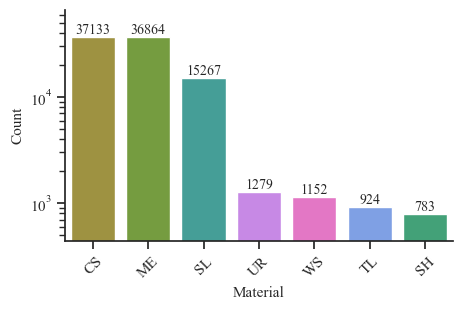

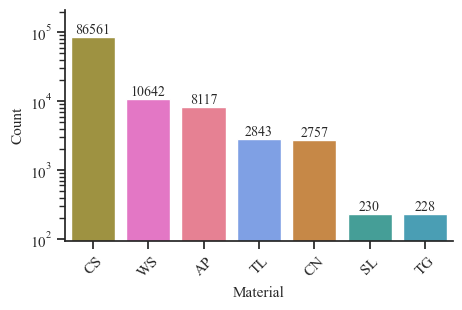

<Figure size 640x480 with 0 Axes>

In [8]:
# font = 'Arial'
font = 'Times New Roman'
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(style="ticks", rc={"font.family": "Times New Roman"})

for roi, ref in refs.items():
    ref = ref.sort_values(by='class_code')
    # Count the occurrences of each class_code
    class_counts = ref['class_code'].value_counts()
    class_counts = ref['class_code'].value_counts().reset_index()
    class_counts.columns = ['class_code', 'count']

    # IDentify the color palette for the region
    region_palette = [color_mapping[cls] for cls in class_counts['class_code']]

    # Plot the bar chart, assigning 'hue' to 'class_code'
    f, ax = plt.subplots(figsize=(5, 3))  
    sns.despine(f) # remove top and right borders
    
    ax = sns.barplot(
        x='class_code', y='count', data=class_counts, 
        hue='class_code', palette=region_palette, 
        dodge=False, legend=False
    )

    # Apply log scale to y-axis
    plt.yscale('log')

    # Add labels to each bar
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # X position of the label
            p.get_height(),                 # Y position of the label
            f'{int(p.get_height())}',       # Label text (the count)
            ha='center',                    # Horizontal alignment
            va='bottom',                    # Vertical alignment
            fontsize=10                      # Font size of the labels
        )

    # plt.title(f'{roi} Class Distribution')
    plt.xlabel('Material', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.xticks(rotation=45)

    ax.margins(y=0.15) # add some upper spacing

    # Save the figure
    out_png = os.path.join(projdir,f'figures/Figure1_{roi}_class_distribution.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    
    plt.show()

plt.tight_layout()
plt.show()

In [9]:
# Footprint area and dispersion metrics by class code

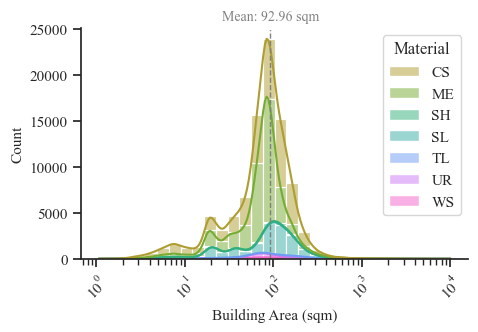

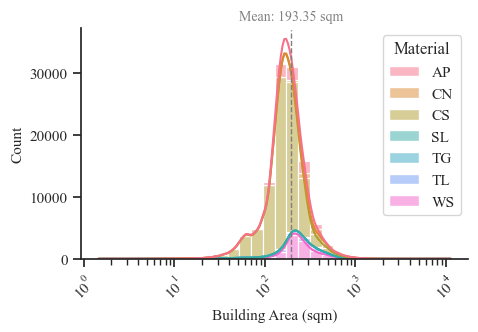

In [10]:
# Plot the distribution of building footprint area

plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(style="ticks", rc={"font.family": "Times New Roman"})

# Loop through the dictionary to create separate histograms
for roi, ref in refs.items():
    ref = ref.sort_values(by='class_code')
    ref['areaUTMsqm'] = ref['areaUTMsqft'] * 0.092903
    
    # Create a figure and axis for each region
    f, ax = plt.subplots(figsize=(5, 3))   
    sns.despine(f) # remove top and right borders

    # Get the color palette
    unique_classes = ref['class_code'].unique()
    region_palette = {cls: color_mapping[cls] for cls in unique_classes if cls in color_mapping}
    
    # Set the x-axis to logarithmic scale with appropriate ticks
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xticks([0.1, 10, 100, 1000, 10000, 100000])
    ax.set_yscale('linear')  # Keep the y-axis linear unless you want log scale
    
    # Create a histogram colored by class_code
    hist = sns.histplot(
        data=ref, 
        x="areaUTMsqm", 
        bins=30, 
        log_scale=True, 
        kde=True, 
        hue="class_code",  # Color by class_code
        multiple="stack",  # Stack the bars for each class
        palette=region_palette,  # You can use class_palette if you have a custom one
        legend=True
    )

    # Calculate the overall mean of 'areaUTMsqft'
    area_mean = ref['areaUTMsqm'].mean() # in sqm

    # Add a vertical dotted line for the mean
    ax.axvline(area_mean, color='gray', linestyle='--', linewidth=1)

    # Add a text label for the mean
    ax.text(
        area_mean, ax.get_ylim()[1] * 1.05,  # Position: x=area_mean, y=90% of y-axis limit
        f'Mean: {area_mean:.2f} sqm', 
        color='gray', 
        fontsize=10,
        rotation=0, 
        va='center', 
        ha='center',
        backgroundcolor='white'
    )
    
    # Retrieve the legend and set the title
    legend = ax.get_legend()
    legend.set_title('Material')
    
    # Set labels and title
    plt.xlabel('Building Area (sqm)', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.xticks(rotation=45)  # Rotate x labels if necessary
               
    # Save the figure
    out_png = os.path.join(projdir,f'figures/Figure1_{roi}_area_dist.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

In [11]:
# Supplement

In [12]:
# Table S1. Microsoft Building Footprint area and distance distributions
# Calculate dispersion metrics for each region
from scipy.spatial import KDTree

knn_by_material = {}
for roi, ref in refs.items():
    knn_by_material[roi] = {}
    # Group the data by 'class_code'
    for class_code, group in ref.groupby('class_code'):
        # Generate the centroid for the group
        centroid = group.geometry.centroid
        # Grab the coordinate pairs
        coords = np.array([(geom.x, geom.y) for geom in centroid])
        # Proceed only if there are at least 2 points in the group
        if len(coords) > 1:
            # Set up the nearest neighbor search
            kdtree = KDTree(coords)
            distances, _ = kdtree.query(coords, k=2)  # k=2 because the nearest point is itself
            # Calculate the average distance to nearest neighbor for this class_code
            knn_by_material[roi][class_code] = distances[:, 1]
        else:
            knn_by_material[roi][class_code] = np.nan  # Handle cases where there are fewer than 2 points

# Create a dataframe from the results
knns = []
for roi, class_distances in knn_by_material.items():
    for class_code, distances in class_distances.items():
        for dist in distances:
            knns.append({'Region': roi, 'class_code': class_code, 'Distance': dist})
knn_df = pd.DataFrame(knns)
print(knn_df.head())

# Calculate mean nearest neighbor distance for each class_code and region
knn_df_mean = knn_df.groupby(['Region', 'class_code'])['Distance'].mean().reset_index()
# mean distance across all classes
print(f"\nAverage distance (all footprints):\n{knn_df_mean.groupby('Region')['Distance'].mean()}\n")

  Region class_code   Distance
0     DC         CS  10.082770
1     DC         CS   6.388587
2     DC         CS  11.458459
3     DC         CS   6.748317
4     DC         CS  10.524797

Average distance (all footprints):
Region
DC        34.556320
Denver    84.360794
Name: Distance, dtype: float64



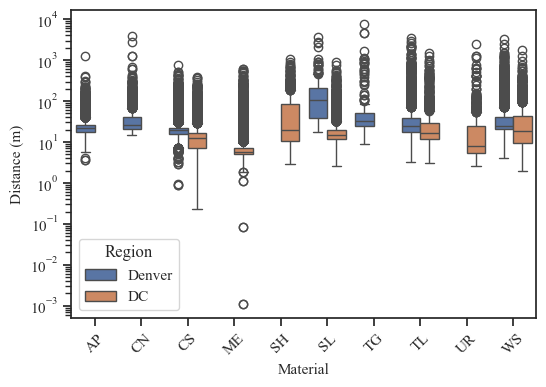

In [13]:
# Sort the class codes
knn_df = knn_df.sort_values(by='class_code', ascending=True).reset_index(drop=True)

# Set the plot
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(style="ticks", rc={"font.family": "Times New Roman"})

f, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(x='class_code', y='Distance', hue='Region', data=knn_df)
plt.yscale('log')
ax.set_xlabel('Material', fontsize=11)
ax.set_ylabel('Distance (m)', fontsize=11)
plt.xticks(rotation=45)

# Save the figure
out_png = os.path.join(projdir, f'figures/FigureX_dc-denver_footprints_knn.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [14]:
# Calculate the area metrics and combine with dispersion for supplement table
area_dist_stats = {}
for roi, ref in refs.items():
    # Calculate the area and side length statistics (see __functions.py)
    area_df = ref.groupby('class_code').apply(footprint_area_stats).reset_index()
    area_df['Region'] = roi # add the region as a column
    # Combine with the nearest neighbor distances
    area_dist_df = pd.merge(area_df, knn_df_mean, on=['Region', 'class_code'])
    area_dist_stats[roi] = area_dist_df

# Merge the two
area_dist_combined = pd.concat(area_dist_stats.values(), ignore_index=True)
area_dist_combined.head()
# Export as a CSV
out_csv = os.path.join(projdir, 'figures/SuppTable_footprint_area_distances.csv')
area_dist_combined.to_csv(out_csv)
print(f"\nSaved to: {out_csv}\n")

area_dist_stats['Denver'] # check the table result


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/figures/SuppTable_footprint_area_distances.csv



,class_code,mean_area,pct90_area,mean_side_length,std_side_length,max_side_length,pct90_longest_side,Region,Distance
0,AP,220.275065,334.693436,15.382730,2.096756,139.575377,21.930919,Denver,26.629368
1,CN,379.317451,590.036484,21.179416,3.249251,86.199454,34.788889,Denver,44.489683
2,CS,173.869085,255.850890,13.564221,2.021024,137.451338,20.190204,Denver,20.549340
3,SL,542.682291,1027.882964,27.105747,5.348558,95.974952,54.098605,Denver,214.805496
4,TG,498.942272,824.956488,22.750724,6.634758,228.912855,49.078230,Denver,175.875115
5,TL,261.383820,440.409775,16.510694,2.280717,102.425388,26.692619,Denver,63.599779
6,WS,250.797337,393.927105,16.692925,2.598482,70.664955,27.524037,Denver,44.576780


In [ ]:
gc.collect() # clear space

In [21]:
# Figure S1. Band correlation matrices
# load the DC stack
fp = os.path.join(projdir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_stack.tif')
dc_stack = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto')
print(da)
# load the full stack
fp = os.path.join(projdir,'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_stack.tif')
denver_stack = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto')
print(f"\n{denver_stack}")

<xarray.DataArray (band: 15, y: 8223, x: 6714)> Size: 3GB
dask.array<open_rasterio-3722b007d1d928f695edcaa45ecda443<this-array>, shape=(15, 8223, 6714), dtype=float32, chunksize=(1, 4997, 6714), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15296
    STATISTICS_MEAN:           610.98447553229
    STATISTICS_MINIMUM:        16
    STATISTICS_STDDEV:         321.59520811687
    STATISTICS_VALID_PERCENT:  91.15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('coastal_blue', 'blue', 'green_i', 'green', '...

<xarray.DataArray (band: 15, y: 14939, x: 6330)> Size: 6GB
dask.array<open_

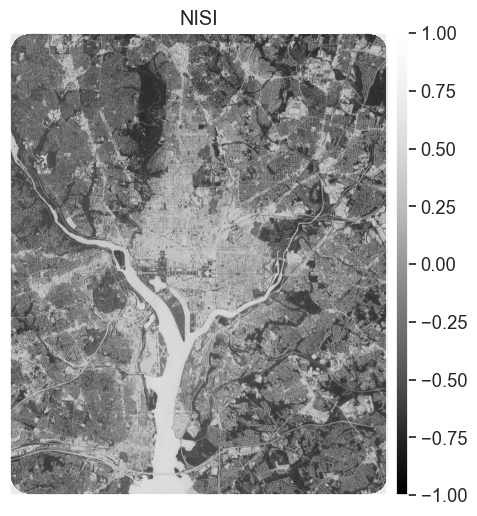

<Axes: title={'center': 'NISI'}>

In [22]:
# check on one of the bands
ep.plot_bands(
    dc_stack[13].squeeze(),
    scale=False,
    vmin=-1,vmax=1,
    title="NISI",
    figsize=(6,6))

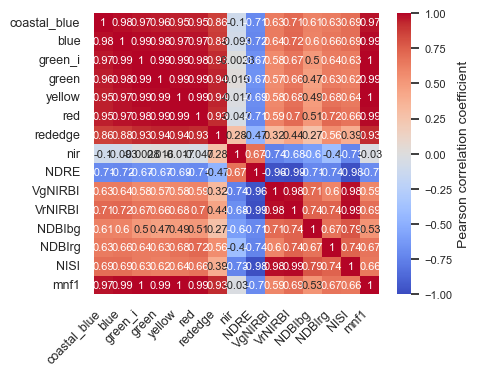

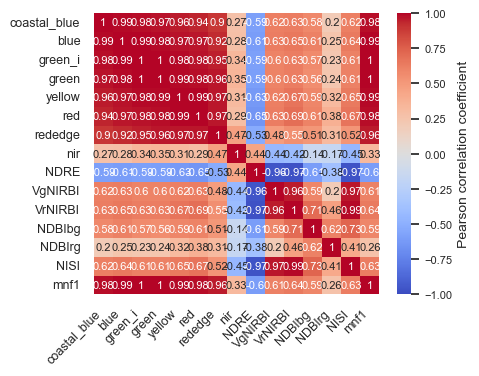

In [24]:
# Get the correlation matrix
# see __functions.py
dc_cor_mat = band_correlations(dc_stack, plot=True) 
denver_cor_mat = band_correlations(denver_stack, plot=True) 

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/figures/FigureS2_Band_Correlations.png


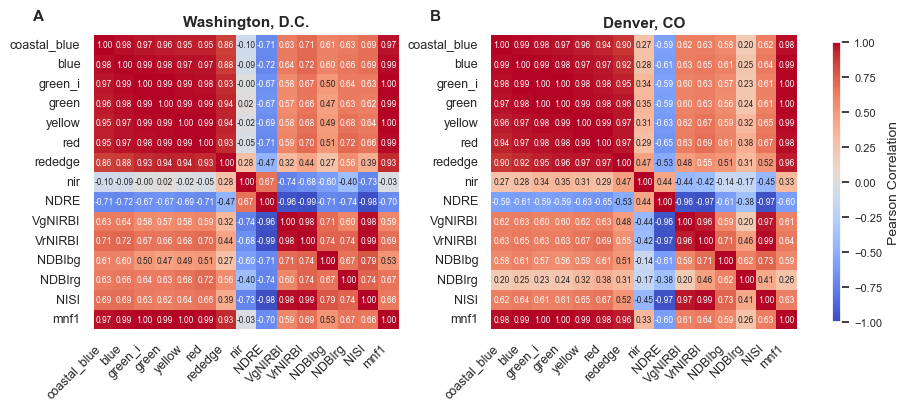

In [41]:
# Create the multi-panel version
out_png = os.path.join(projdir, 'figures/FigureS2_Band_Correlations.png')

# get a list of band names
bands = list(dc_stack.attrs.get('long_name', [f"Band {i+1}" for i in range(da.shape[0])]))
# Prepare inputs for multi-panel plot
data_arrays = [(dc_cor_mat, bands), (denver_cor_mat, bands)]
titles = ["Washington, D.C.", "Denver, CO"]

# Create multi-panel plot
num_panels = len(data_arrays)
fig, axes = plt.subplots(1, num_panels, figsize=(9,4), constrained_layout=True)

# Ensure axes is iterable (for single-panel case)
if num_panels == 1:
    axes = [axes]

# Initiate the color bar
norm = plt.Normalize(vmin=-1, vmax=1)
cmap = "coolwarm"

# Iterate through data arrays and plot
for i, (cor_mat, band_labels) in enumerate(data_arrays):
    sns.heatmap(
        cor_mat,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        norm=norm,
        xticklabels=band_labels,
        yticklabels=band_labels,
        cbar=False,  
        annot_kws={"size": 6},
        ax=axes[i]
    )
    axes[i].set_title(titles[i], fontsize=11, weight="bold")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right", fontsize=9)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=9)
    # axes[i].set_xlabel("Bands", fontsize=9, weight="bold")
    # axes[i].set_ylabel("Bands", fontsize=9, weight="bold")

    # Add sub-label (A, B, ...)
    axes[i].text(-0.2, 1.05, chr(65 + i), transform=axes[i].transAxes, fontsize=11, weight="bold")

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=30, shrink=0.95)
cbar.set_label('Pearson Correlation', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Save the plot
if out_png:
    plt.savefig(out_png, dpi=300, bbox_inches="tight", format="png")
    print(f"Saved to: {out_png}")

plt.show()

In [ ]:
# Figure S2. Hyperparameter results

In [37]:
fp = os.path.join(projdir,'results/resnet18/tuning/resnet18_grid_search_results.csv')
tuning_df = pd.read_csv(fp)
tuning_df.head(12)

,trial,epoch,batch_size,window_size,learning_rate,weight_decay,accuracy,f1_score,train_loss,val_loss,time_ep
0,0,1,32,78,0.01,0.00001,38.454576,0.454619,1.772893,1.466633,3.25
1,0,2,32,78,0.01,0.00001,43.240186,0.436734,1.482872,1.456673,3.35
2,0,3,32,78,0.01,0.00001,57.732775,0.583495,1.367790,1.228961,3.42
3,0,4,32,78,0.01,0.00001,50.367689,0.533238,1.230571,1.303825,3.38
4,0,5,32,78,0.01,0.00001,41.022740,0.461519,1.090379,1.758595,3.33
5,0,6,32,78,0.01,0.00001,38.443263,0.441192,0.905829,1.736805,3.38
6,0,7,32,78,0.01,0.00001,49.077950,0.512800,0.747294,1.414276,3.40
7,0,8,32,78,0.01,0.00001,61.217332,0.619434,0.452533,1.197468,3.40
8,0,9,32,78,0.01,0.00001,64.656635,0.645323,0.324811,1.208729,3.45
9,0,10,32,78,0.01,0.00001,64.645322,0.644943,0.273739,1.269782,3.25


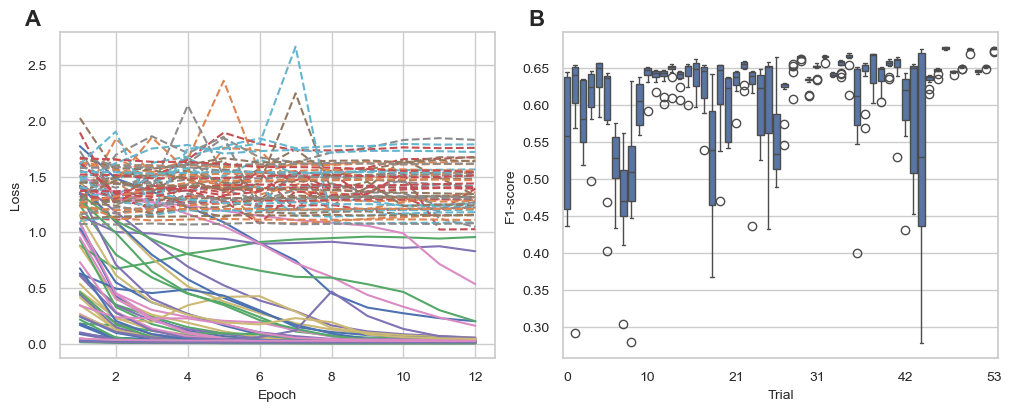

In [69]:
# Define figure and subplots
sns.set_theme(style="whitegrid")  # Use a white grid for modern aesthetics

# Define figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)  # 1 row, 2 columns

# Plot 1: Train and Validation Losses Across Trials
for trial in tuning_df['trial'].unique():
    trial_data = tuning_df[tuning_df['trial'] == trial]
    axes[0].plot(trial_data['epoch'], trial_data['train_loss'], label=f'Trial {trial} - Train', linestyle='-')
    axes[0].plot(trial_data['epoch'], trial_data['val_loss'], label=f'Trial {trial} - Val', linestyle='--')

# Plot A
axes[0].set_xlabel('Epoch', fontsize=10)
axes[0].set_ylabel('Loss', fontsize=10)
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].text(-0.08, 1.02, 'A', transform=axes[0].transAxes, fontsize=16, weight='bold')

# Plot B: F1 Score Distribution Across Trials
sns.boxplot(x='trial', y='f1_score', data=tuning_df, ax=axes[1])

# Customize Plot B
axes[1].set_xlabel('Trial', fontsize=10)
axes[1].set_ylabel('F1-score', fontsize=10)
axes[1].text(-0.08, 1.02, 'B', transform=axes[1].transAxes, fontsize=16, weight='bold')

# Limit the number of trial axis labels to 4 evenly spaced breaks
trial_ticks = tuning_df['trial'].unique()
trial_indices = [int(i) for i in np.linspace(0, len(trial_ticks) - 1, 6)]  # Select 4 indices evenly
axes[1].set_xticks(trial_indices)
axes[1].set_xticklabels([trial_ticks[i] for i in trial_indices], fontsize=10)

axes[0].tick_params(axis='x', labelsize=10)  # Adjust x-axis tick label size for first subplot
axes[0].tick_params(axis='y', labelsize=10)  # Adjust y-axis tick label size for first subplot
axes[1].tick_params(axis='x', labelsize=10)  # Adjust x-axis tick label size for second subplot
axes[1].tick_params(axis='y', labelsize=10)

# Save the combined figure
out_png = os.path.join(projdir, f'figures/FigureS2_hyper_tuning.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight', format='png')

plt.show()